# Benchmarking some gates

In this tutorial we will benchmarks for quantum software and we will have a look at some performance metrics of two well quantum python libraries: Qiskit (Abraham et al., 2019(https://qiskit.org/)) and Qulacs (“Qulacs”, 2018(https://github.com/qulacs/qulacs)). 


## Contents 

1. [Introduction](#introduction)

    1.1. [Quantum computing](#quantumcomp)
      
    1.2. [Qiskit and Qulacs](#qiskitqulacs)

2. [Single gates](#gates)

3. [Quantum adder](#adder)
   
4. [Shor's algorithm](#Shors)

5. [Random circuits](#RC)
        
    3.1. [Implementation 1](#RC1)
    
    3.2. [Implmentation 2](#RC2)
    
    3.3. [Implmentation 3](#RC3)
    
6. [Conclusion](#conclusion)

## 1. Introduction <a id='introduction'></a>

### 1.1. Quantum computing <a id='quantumcomp'></a>
In recent years quantum computing has become a buzzword and the possibility of a fully working quantum computer is becoming closer and closer. 

Both, quantum knowledge and technology have grown exponentially fast, even faster than classical computing in its early years, but still developing a non-trivial size quantum computer is not straight forward. We will probably have to wait some more years to witness their full power and applicability (although IBM has announced their roadmap with 1000+ qubits by the end of 2023!. 

The quantum computers available nowadays (eg. IBM, Google, QuTech, etc.) are what we call "Noisy Intermediate-Scale Quantum devices" (NISQ). They are quantum computers capable of executing quantum algorithms and calculations but where the sources of errors limits how reliable they are. 

NISQ devices can be benchmarked using the "quantum volume" (introduced by IBM), which takes into account not only the number of qubits (called the width of a circuit) but also the number of operations (called the depth of a circuit) a quantum computer can handle. The depth of a circuit, is influenced by things such as the number of qubits, how qubits are interconnected, gate and measurement errors, device cross talk, circuit compiler efficiency, and more.
Therefore, it is a good indicator of the relative complexity of problems that can be solved by a quantum computer. The larger the number, the more powerful the quantum computer is  and the higher the potential for exploring solutions to real world problems across industry, government, and research is. More info can be found at https://medium.com/qiskit/what-is-quantum-volume-anyway-a4dff801c36f

Classical simulation of quantum computation is vital for the study of new algorithms and architectures. As experimental researchers move closer to realising quantum computers of sufficient complexity to be useful, their work must be guided by an understanding of what tasks we can hope to perform. This in turn means we must explore an algorithm’s scaling, its robustness versus errors and imperfections, and the relevance of limitations of the underlying hardware. Because of these requirements simulation tools are needed on many different classical architectures; while a workstation may be sufficient for the initial stages of examining an algorithm, further study of scaling and robustness may require more powerful computational resources. Flexible, multi-platform supporting simulators of quantum computers are therefore essential. Quantum simulators, allow quantum algorithm designers to simulate the execution of their quantum circuits on a quantum computer. The simulator defines a low-level quantum assembly language namely Quantum Code which allows the users to describe their circuits in a simple textual source code file. The source code file is then used as the input of the simulator which executes its content.

Further it is important these simulations are very efficient since they are often repeated many times, for example to study the influence of many parameters, or the behaviour of circuits under noise. But it is expensive to exactly simulate a quantum system using a classical system, since a high-dimensional complex vector must be maintained with high fidelity. Both the memory requirements, and the time required to simulate an elementary circuit operation, grow exponentially with the number of qubits. To simulate quantum computers even of the size already experimentally realised, it is necessary that a classical simulator take full advantage of the performance optimisations possible of high performance classical computing.



###  1.2. Qiskit and Qulacs <a id='qiskitqulacs'></a>

Before going into the actual code, below some summary properties of these simulators (for more info we refer the reader to the documentation pages of the software https://qiskit.org/documentation/, http://docs.qulacs.org/en/latest/guide/2.0_python_advanced.html#).

#### Qiskit
* The qubits are stored in a QuantumRegister and the measurement of the qubits are stored in a "ClassicalRegister". 
* The QuantumRegister and ClassicalRegister make the QuantumCircuit.
* If we pass the entire quantum and classical registers as arguments to measure, the function will by default make a total measurement on the system, and store each qubit’s measurement results to the corresponding index in the ClassicalRegister: classical register numbers are backwards (based on the bit string  as usually defined in classical computer such that the LSB (least significant bit) is the right-most index)
* The QuantumCircuit object is just a list of instructions, which aren’t actually carried out until we run it on some simulator (backend)
* To execute the circuit on a certain backend you have to execute the whole circuit with that backend. That creates an object that handles a job, from the job you can extract the result.
* In the case of the 'qasm_simulator' backend the output is the probability of a given measurment after 1024 circuit run
* In the case of the 'statevector_simulator' backend, the circuit is executed a single shot and it returns the final quantum statevector of the simulation (wavefunction, 2n amplitudes) after evolving the zero state through the circuit
* Both these backends are still classical (not calling any quanutm devices)
* Qiskit Uses QASM simulator as quantum assembly
* N-qubit Clifford operator are stored as a length 2N StabilizerTable 
* You can get intermediate states from a simulator by applying a snapshot(slot) instruction at various spots in the circuit
* gates are represented as np.arrays
* quantum registers and classical registers are a QASM string register

#### Qulacs 

It is not a well known library, but it has some great features that are useful for researchers. One of the most important features are that it can run on a GPU for faster simulations, in this notebook we will only use qulacs on a CPU. It also claims to compress circuits to simulate faster than other libraries. Nowadays there is also a Cirq interface for Qulacs (https://github.com/qulacs/cirq-qulacs).

The core simulation program is written in C/C++ associated with a lightweight python interface.

Some details:
* Quantum states allocates and manages 2n complex arrays on the CPU/GPU with the precision of complex128.
* Necessary memory is secured at the time of instance creation and released when the instance is destroyed
* All the gates are stored in a QuantumCircuit of a certain amount of qubits. 
* Quantum states have classical registers as arrays of integers with variable length. The classical register is used to write the result of the Instrument operation or to describe a gate that executes conditions as the result of the classical register. 
* Special gates are those that have a pre-specified gate matrix and can only perform limited deformations on quantum gates. For example, Pauli gate, rotation Pauli gate, projection measurement, etc. are supported. The advantage of a special gate is that the update function of the quantum state is more efficient than a general gate with limited properties. 
* Gates can be defined as dense or sparse matrices
* With a lot of qubits you will get an out of memory error, because Qulacs is not memory efficient. 
* You need a separate QuantumState and this state has to be set to the one or zero state for measurement.
* QASM is used as quantum assembly language.
* To execute the circuit on the quantum state you have to update that state with the circuit.
* It measures a vector of the quantum state.
* By combining quantum gates into a single quantum gate, the number of quantum gates can be reduced and the time required for numerical calculations can be reduced. (Of course, if the number of target qubits increases, or if a quantum gate with a dedicated function is synthesized into a quantum gate without a dedicated function, the total calculation time may not decrease. It depends.)



Every library applies gates differently, Qulacs puts the gates in a queue that will be executed after calling all the gates, while Qiskit applies the gates immediately and measures the qubit at the end.

Every library also differs in the gate set available, in the table below we present this gates:


| Quantum simulators | Language | Can run on | Single-Qubit Gates | Multiqubit Gates|
| :----------------- |:---------| :------------- | ------------------ | --------------- |
| Qiskit | Python | CPU | X, Y, Z, H, S, S†, T, T†, Rx, Ry, Rz, U1, U2, U3 | CNOT, CZ, CY, SWAP, Toffoli, CSWAP 
| Qulacs | Python/C++ | CPU or GPU | I, X, Y, Z, H, S, S†, T, T†,sqrtX, sqrtX†, sqrtY, sqrtY†, P0, P1, RX, RY, RZ, U1, U2, U3 | CNOT, CZ, SWAP |


## 4. Single gates X, H, T and CNOT  <a id='gates'></a>
In order to optimize the execution of circuits in simulators, it is important to understand how different gates perform. This means, understanding how the simulation time and memory allocation of these gates scales with the number of qubits. 
 
Below we define a some profiling functions (time and memory), circuits to benchmark and a code to run the benchmarks. We compare qiskit vs qulacs for different numbers of qubits. Each circuit is run 50 times.

The circuits to execute are:

1) a uniform superposition of states: applying a Hadamard operation to each qubit

2) a sequence of gate operations (H 0), (CNOT 0 1), (CNOT 1 2), …, (CNOT N-2, N-1). The result of this quantum circuit is to put the quantum computer in the maximally entangled state 

3) application of X gates: only perform a permutation of the elements of the state. In other words, the arithmetic intensity of these operations is very low and the performance is mainly limited by the memory bandwidth.

4) application of T gates

In [85]:
# import packages
#import objgraph
import linecache
import os
import tracemalloc
import time
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.providers.aer import StatevectorSimulator
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

In [86]:
# define profiling functions
def get_obj_graph(func, *args, **kwargs):
#     objgraph.show_most_common_types()
    print('Growth of objects')
    objgraph.show_growth()
    func(*args, **kwargs)
    objgraph.show_growth()
    

def display_top(snapshot, key_type='lineno', limit=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))
    
def measure(times, func, *args, tt_tot = 0.0, rss_tot = 0.0):
    tracemalloc.start()
    for t in range(times):
        t_start = time.perf_counter()
        snapshot1 = tracemalloc.take_snapshot()
        func(*args)
        snapshot2 = tracemalloc.take_snapshot()
        t_stop = time.perf_counter()
        t_tot = t_stop - t_start
        tt_tot += t_tot
        top_stats = snapshot2.compare_to(snapshot1, 'lineno')
        rss_tot += sum(stat.size for stat in top_stats)
    tracemalloc.stop()  
    return tt_tot, rss_tot

In [87]:
# define circuits to profile QISKIT
# should we add measurments circ.measure(q, c)?

def qiskit_x(qubits, method="statevector", precision="single"):
    # defining the device 
    q = QuantumRegister(p, 'q')
    c = ClassicalRegister(p, 'c')
    circ = QuantumCircuit(q, c)
    circ.x(q)

    # the default backend
    backend = Aer.get_backend('statevector_simulator')
    state = execute(circ, backend).result()

def qiskit_hadamard(qubits, method="statevector", precision="single"):
    # defining the device 
    q = QuantumRegister(qubits, 'q')
    print(qubits)
    c = ClassicalRegister(p, 'c')
    
    circ = QuantumCircuit(q, c)
    circ.h(q)
    
    #define the backend
    backend = StatevectorSimulator(precision=precision, method=method)
    state = execute(circ, backend).result()
    
def qiskit_cnot(qubits, method="statevector", precision="single"):
    # defining the device 
    q = QuantumRegister(p, 'q')
    c = ClassicalRegister(p, 'c')
    circ = QuantumCircuit(q, c)

    circ.h(0)
    for i in (range(1, p)): 
        circ.cnot(0, i)

    # the default backend
    backend = Aer.get_backend('statevector_simulator')
    state = execute(circ, backend).result().
    

def qiskit_t(qubits, method="statevector", precision="single"):
    # defining the device 
    q = QuantumRegister(p, 'q')
    c = ClassicalRegister(p, 'c')
    circ = QuantumCircuit(q, c)
    circ.t(q)

    # the default backend
    backend = Aer.get_backend('statevector_simulator')
    state = execute(circ, backend).result()

SyntaxError: invalid syntax (<ipython-input-87-f83370ff78cf>, line 40)

In [88]:
# define circuits to profile qulacs

def qulacs_hadamard(p):
    # defining the device
    state = QuantumState(p)
    state.set_zero_state()
    circuit = QC(p)

    # apply Hadamard on every qubit
    for i in range(p):
        circuit.add_H_gate(i)
    # measure done by defualt
    # execute
    circuit.update_quantum_state(state)
    output = state
    
    
def qulacs_cnot(p):
    state = QuantumState(p)
    state.set_zero_state()

    circuit = QC(p)


    for i in range(1, p):
        circuit.add_CNOT_gate(0, i)

    circuit.update_quantum_state(state)
    output = state
    
    
def qulacs_t(p):
    state = QuantumState(p)
    state.set_zero_state()

    circuit = QC(p)
    t_start = time.perf_counter()

    for i in range(p):
        # check
        circuit.add_T_gate(i)

    circuit.update_quantum_state(state)
    output = state
    
def qulacs_x(p):
    state = QuantumState(p)
    state.set_zero_state()

    circuit = QC(p)
    t_start = time.perf_counter()

    for i in range(p):
        # check
        circuit.add_x_gate(i)

    circuit.update_quantum_state(state)
    output = state

In [89]:
# Run benchmarks

# Maximum amount of qubits we are going to simulate
qubits = 20

# backend
method = ["statevector"] #qasm_simulator'

# functions to benchmark
function_qiskit = [qiskit_hadamard, qiskit_cnot, qiskit_x, qiskit_t]
#function_qulacs = [qulacs_hadamard, qulacs_cnot, qulacs_x, qulacs_t]

function = function_qiskit #+ function_qulacs

# number of times to run benchmark 
times = 1

results = {}
for m in method:
    for f in function:
        # Arrays to store results for running time and memory allocation
        time = np.array([], dtype=float)
        mem = np.array([], dtype=float)
    
        for p in range(2, qubits):
        
            #tt_tot, rss_tot = measure(times, f, p, m)
            #get_obj_graph(f, p, m)
        
            rss_avg = rss_tot / times
            mem = np.append(mem, [rss_avg])
            t_avg = tt_tot / times
            time = np.append(time, [t_avg])    
           
        if "gpu" in m:
            device = "gpu"
        else:
            device = "cpu"
        results[f.__name__ + "_mem_" + m] = mem
        results[f.__name__ + "_time_" + m] = time
    print(results)


{'qiskit_hadamard_mem_statevector': array([101308., 101308., 101308., 101308., 101308., 101308., 101308.,
       101308., 101308., 101308., 101308., 101308., 101308., 101308.,
       101308., 101308., 101308., 101308.]), 'qiskit_hadamard_time_statevector': array([0.09476902, 0.09476902, 0.09476902, 0.09476902, 0.09476902,
       0.09476902, 0.09476902, 0.09476902, 0.09476902, 0.09476902,
       0.09476902, 0.09476902, 0.09476902, 0.09476902, 0.09476902,
       0.09476902, 0.09476902, 0.09476902]), 'qiskit_cnot_mem_statevector': array([101308., 101308., 101308., 101308., 101308., 101308., 101308.,
       101308., 101308., 101308., 101308., 101308., 101308., 101308.,
       101308., 101308., 101308., 101308.]), 'qiskit_cnot_time_statevector': array([0.09476902, 0.09476902, 0.09476902, 0.09476902, 0.09476902,
       0.09476902, 0.09476902, 0.09476902, 0.09476902, 0.09476902,
       0.09476902, 0.09476902, 0.09476902, 0.09476902, 0.09476902,
       0.09476902, 0.09476902, 0.09476902]), 'qi

Plotting...

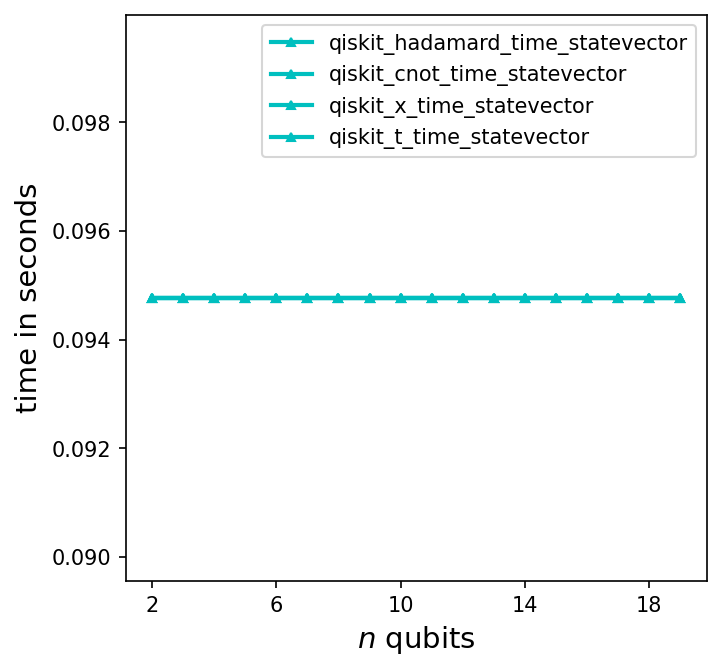

In [98]:
# TIME
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150) 
y = range(2, qubits)
for key, value in results.items():
    if "time" in key:
        ax.plot(y, value, 'c', label=key, linewidth=2, marker='^', markersize=4)
plt.xticks(np.arange(2, qubits, step=4))

plt.xlabel('$n$ qubits', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
ax.legend()

plt.show()

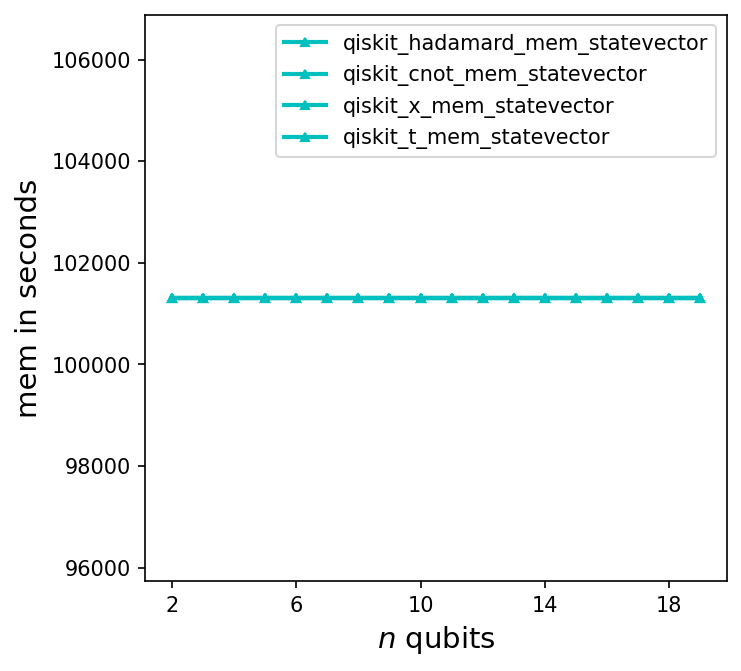

In [99]:
# MEM
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150) 
y = range(2, qubits)
for key, value in results.items():
    if "mem" in key:
        ax.plot(y, value, 'c', label=key, linewidth=2, marker='^', markersize=4)
plt.xticks(np.arange(2, qubits, step=4))

plt.xlabel('$n$ qubits', fontsize=14)
plt.ylabel('mem in seconds', fontsize=14)
ax.legend()

plt.show()

*** TODO: can we get more insight into this?*** 
    I would have expected and increase with teh number of qubits, but this seems not to happen. Is this becasue we are dealing wiht single gate qubits?

### quantum adder
### Shor


## 5 Random circuits<a id='RC'></a>

### 5.1. Implementation 1 <a id='RC1'></a>

A random circuit contains  a  random  sequence  of  gates from a given set. Here we will follow the algorithm from https://arxiv.org/abs/1608.00263 to generate the random circuits. The topology is fixed (a linear array or a grid depending on 1D or 2D) for a given depth and number of qubits, but it randomises the sequence of single qubit gates. The total number of gates goes like $O(n*d), d=$depth of circuit and the ratio between single and control gates is fixed to 1.2 $\pm$ 0.2

The general algorithm goes as follow:
- Start with a cycle of Hadmards 
- Follow by some controlled-phase (CZ) gates 
- Folow by single-qubit gates chosen at random from the set {X1/2,Y1/2,T} at all qubits that are not occupied by the CZ gates at the same cycle (subject to the restrictions below). 

Single-qubit gates are placed subject to the following rules:
- Place a gate at qubit q only if this qubit is occupied by a CZ gate in the previous cycle
- Place  a  T  gate  at  qubit q if there are no single-qubit gates in the previous cycles at qubit q except for the initial cycle of Hadamard gates.
- Any  gate  at  qubit q should be different from the gate at qubit q in the previous cycle

As a brief background, if we think of the probability amplitudes of a single qubit as a vector in a 3D sphere, all single qubit gates modify the vector by rotating it in the "Bloch" sphere. The X gate rotates it 180 degrees. The T-gate is a single qubit 45 degree shift and the X1/2(Y1/2) are a $\pi/2= 90^\circ$ rotations around the X(Y) axis in the Bloch sphere. The Controlled Z (CZ) is a two-qubit gate and is the controlled version of the Z gate (same as CNOT being the controlled version of the X-gate). This gate applies a Z operation (change of sign in the |1> state) on the target qubit when the control is |1>. It can also be described as a conditional operation that performs a sign shift only when the two qubit state is |11>.



In [ ]:
# Random Circuit 1 qiskit statevector
# amount of qubits we are going to run
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qulacs import Observable, QuantumState, QuantumCircuit as QC
import time
import tracemalloc
import resource
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from qiskit.visualization import plot_histogram
import numpy as np
import random

depth = 20
width = 20

qisRC1t = np.array([], dtype=float)
qisRC1m = np.array([], dtype=float)

# array with every possible gate for this implementation 
arr = ['T', 'X(1/2)', 'Y(1/2)']

qubitsArrayCZ_prev = width*[False]
qubitsArrayT_prev = width*[False]
qubitsArrayX_prev = width*[False]
qubitsArrayY_prev = width*[False]

qubitsArrayCZ = width*[False]
qubitsArrayT = width*[False]
qubitsArrayX = width*[False]
qubitsArrayY = width*[False]

# initializing variable
CZGate = True
CZ = width/2.0
counter = 0 
times = 10

#ratio_tot = 0.0
ratio_avg = 0.0

for w in range(2, width):
    print ("width {}".format(w))
    tt_tot = 0.0
    rss_tot = 0.0
    ratio_tot = 0.0
    # Randomly applying the random circuit gate set
    for t in range(0, times):
        CZ_tot = 0.0
        T_tot = 0.0
        X_tot = 0.0
        Y_tot = 0.0
        single_tot = 0.0
        
        tracemalloc.start()  
        t_start = time.perf_counter()
    
        # defining the device 
        q = QuantumRegister(w, 'q')
        c = ClassicalRegister(w, 'c')
        circR1 = QuantumCircuit(q, c)
    
        # apply cycle Hadamards
        circR1.h(q)
    
        for i in range(0, depth):
            if w < 4:
                initCZgates = int(w/2.0)
            else:
                initCZgates = int((w)/4.0) # decide on this one
            # apply CZ randomly
            for j in range(0, initCZgates):
                while CZGate:
                    q0 = random.randint(0, w - 2 )
                    q1 = q0 + 1
                    if i == 0:
                        if qubitsArrayCZ[q0] == False and qubitsArrayCZ[q1] == False:
                            circR1.cz(q0,q1)
                            qubitsArrayCZ[q0] = True
                            qubitsArrayCZ[q1] = True
                            CZGate = False
                    elif i != 0 and qubitsArrayCZ_prev[q0] == False:
                        if qubitsArrayCZ[q0] == False and qubitsArrayCZ[q1] == False:
                            circR1.cz(q0,q1)
                        
                            qubitsArrayCZ[q0] = True
                            qubitsArrayCZ[q1] = True
                            CZGate = False
                    else:
                        counter += 1
                    if counter > 2:
                        break
                counter = 0 
                        
                CZGate = True
        
            # apply single gate at random in rest qubits if previous gate is CZ:
            for q in range(0, w):   
           
                if qubitsArrayCZ[q] == False:
                    if i == 0:
                        while True:
                            rGate = np.random.choice(arr)
                            if rGate == 'T' and qubitsArrayT_prev[q] == False:
                                circR1.t(q)
                                qubitsArrayT[q] = True 
                                break
                            elif rGate == 'X(1/2)' and qubitsArrayX_prev[q] == False:
                                circR1.x(q)
                                qubitsArrayX[q] = True
                                break
                            elif rGate == 'Y(1/2)' and qubitsArrayY_prev[q] == False:
                                circR1.y(q)
                                qubitsArrayY[q] = True
                                break
                            else:
                                counter = counter + 1
                            if counter > 10:
                                break

                    elif i != 0 and qubitsArrayCZ_prev[q] == True:
                        while True:
                            rGate = np.random.choice(arr)
                            if rGate == 'T' and qubitsArrayT_prev[q] == False:
                                circR1.t(q)
                                qubitsArrayT[q] = True 
                                break
                            elif rGate == 'X(1/2)' and qubitsArrayX_prev[q] == False:
                                circR1.x(q)
                                qubitsArrayX[q] = True
                                break
                            elif rGate == 'Y(1/2)' and qubitsArrayY_prev[q] == False:
                                circR1.y(q)
                                qubitsArrayY[q] = True
                                break
                            else:
                                counter += 1
                            if counter > 10:
                                break
                    counter = 0
            # compute ratio control and single gates
            CZ = qubitsArrayCZ.count(True)
            T = qubitsArrayT.count(True)
            X = qubitsArrayX.count(True)
            Y = qubitsArrayY.count(True)
            
            single = T + Y + X
            CZ_tot += CZ
            T_tot += T
            Y_tot += Y
            X_tot += X
            single_tot += single
            qubitsArrayT_prev = qubitsArrayT
            qubitsArrayX_prev = qubitsArrayX
            qubitsArrayY_prev = qubitsArrayY
            qubitsArrayCZ_prev = qubitsArrayCZ
            qubitsArrayT = [ False for x in range(width)]
            qubitsArrayX = [ False for x in range(width)]
            qubitsArrayY = [ False for x in range(width)]
            qubitsArrayCZ = [ False for x in range(width)]
            # compute ratio control and single gates

        # the default backend
        backend = Aer.get_backend('statevector_simulator')
        state = execute(circR1, backend).result().get_statevector()

        snapshot = tracemalloc.take_snapshot()
        top_stats = snapshot.statistics('lineno')
        tracemalloc.stop()
        max_rss = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
        rss_tot += max_rss

        t_stop = time.perf_counter()
        t_tot = t_stop - t_start

        tt_tot += t_tot

        if t < times - 1:
            del q
            del c
            del circR1
            del state        


        #print (" Time {}".format(t))
        #print ("Ratio single/controlled: {}".format(single_tot/(CZ_tot/2.0)))
        #print (" T gates: {}".format(T_tot))
        #print (" X gates: {}".format(X_tot))
        #print (" Y gates: {}".format(Y_tot))
        #print (" CZ gates: {}".format(CZ_tot/2.0))
       # print (" Total  gates: {}".format(CZ_tot/2.0 + single_tot))
        #print ("time: {}".format(t_tot))
        ratio_tot += (single_tot/(CZ_tot/2.0))
    ratio_avg = ratio_tot/times
    ratio_tot = 0.0
    rss_avg = rss_tot / times 
    qisRC1m = np.append(qisRC1m, [rss_avg])
    t_avg = tt_tot / times
    qisRC1t = np.append(qisRC1t, [t_avg])
    #print ("time_av: {}".format(t_avg))
    print ("ratio_av: {}".format(ratio_avg))
print (qisRC1t)
print(qisRC1m)              
 

In [ ]:
# to visualize last random circuit:
circR1.draw(output='mpl')



In [ ]:
y1 = range(2, width)

# TIME
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150) 
ax.plot(y1, qisRC1t, 'c', label='Qiskit_RC1', linewidth=2, marker='^', markersize=4)
#ax.plot(y1, qulT, 'm', label='Qulacs', linewidth=2, marker='x', markersize=4)
#plt.xticks(np.arange(2, qisQubitsCNOT, step=4))
plt.title('Random circuit 1', fontsize=14)

plt.xlabel('$n$ qubits', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
ax.legend()

plt.show()

In [ ]:
# memory
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150) 
ax.plot(y1, qisRC1m, 'c', label='Qiskit_RC1', linewidth=2, marker='^', markersize=4)
#ax.plot(y1, qulT, 'm', label='Qulacs', linewidth=2, marker='x', markersize=4)
#plt.xticks(np.arange(2, qisQubitsCNOT, step=4))
plt.title('Random circuit 1', fontsize=14)

plt.xlabel('$n$ qubits', fontsize=14)
plt.ylabel('memory allocated', fontsize=14)
ax.legend()

plt.show()

For the memory we are measuring the maximum resident set size (portion of memory occupied by a process that is held in main memory (RAM)) it takes to run.

**TODO implement this in qulacs, maybe improve where and how the time of the circuit is measured**

### 5.2 Implementation 2  <a id='RC2'></a>
Below a random circuit with no restrictions at all, using the same gate set as before:

In [ ]:
# Random Circuit 2 qiskit statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qulacs import Observable, QuantumState, QuantumCircuit as QC
import time
import tracemalloc
import resource
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from qiskit.visualization import plot_histogram
import numpy as np
import random


# an array with every Clifford gate
clifford = ['H', 'S', 'X', 'Y', 'Z', 'CX']

qisRC2t = np.array([], dtype=float)
qisRC2m = np.array([], dtype=float)

qisQubitsRC2 = 20
times = 10

for k in range(2, qisQubitsRC2):
    tt_tot = 0.0
    rss_tot = 0.0     
    for t in range(times):
        tracemalloc.start()
        t_start = time.perf_counter()

        # defining the device
        q = QuantumRegister(k, 'q')
        c = ClassicalRegister(k, 'c')
        circR1 = QuantumCircuit(q, c)

        for i in range(depth):
            amount = np.random.randint(0, 3)
            for j in range(amount):
                # chosing a random gate and applying it on a random circuit
                rGate = np.random.choice(arr)
                i0 = np.random.randint(0, k)
                i1 = np.random.randint(0, k)
                while i0 == i1: i1 = np.random.randint(0, k)

                if rGate == 'H':
                    circR1.h(q[i0])
                elif rGate == 'T':
                    circR1.t(q[i0])
                elif rGate == 'X':
                    circR1.x(q[i0])
                elif rGate == 'Y':
                    circR1.y(q[i0])
                elif rGate == 'C(Z)':
                    circR1.cz(q[i0], q[i1])

        circR1.measure(q, c)

        # the default backend to run the whole circuit
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(circR1, backend)
        result = job_sim.result()
        
        snapshot = tracemalloc.take_snapshot()
        top_stats = snapshot.statistics('lineno')
        tracemalloc.stop()
        max_rss = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
        rss_tot += max_rss 

        t_stop = time.perf_counter()
        t_tot = t_stop - t_start
        tt_tot += t_tot
        
    rss_avg = rss_tot / times
    qisRC2m = np.append(qisRC2m, [t_avg])
        
    t_avg = tt_tot / times
    qisRC2t = np.append(qisRC2t, [t_avg])
    
print(qisRC2t)

The code for measuring the time it takes to run this random circuit implementation in Qulacs:

In [ ]:
# Random Circuit 2 qulacs
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qulacs import Observable, QuantumState, QuantumCircuit as QC
import time
import tracemalloc
import resource
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from qiskit.visualization import plot_histogram
import numpy as np
import random

qulRC2t = np.array([], dtype=float)
qulRC2m = np.array([], dtype=float)

qulQubitsRC2 = 20
times = 10

for k in range(2, qulQubitsRC2):
    rss_tot = 0.0
    tt_tot = 0.0
    for t in range(times):
        tracemalloc.start()
        t_start = time.perf_counter()

        state = QuantumState(k)
        state.set_zero_state()

        circuit = QC(k)

        for i in range(depth):
            amount = np.random.randint(0, 3)
            for j in range(amount):
                rGate = np.random.choice(arr)
                i0 = np.random.randint(0, k)
                i1 = np.random.randint(0, k)
                while i0 == i1: i1 = np.random.randint(0, k)

                if rGate == 'H':
                    circuit.add_H_gate(i0)
                elif rGate == 'T':
                    circuit.add_T_gate(i0)
                elif rGate == 'X':
                    circuit.add_X_gate(i0)
                elif rGate == 'Y':
                    circuit.add_Y_gate(i0)
                elif rGate == 'C(Z)':
                    circuit.add_CZ_gate(i0, i1)

        circuit.update_quantum_state(state)
        output = state
        del circuit
        del state
                
        snapshot = tracemalloc.take_snapshot()
        top_stats = snapshot.statistics('lineno')
        tracemalloc.stop()
        max_rss = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

        rss_tot += max_rss

        t_stop = time.perf_counter()
        t_tot = t_stop - t_start

        tt_tot += t_tot
        
    rss_avg = rss_tot / times
    qulRC2m = np.append(qulRC2m, [rss_avg])

    t_avg = tt_tot / times
    qulRC2t = np.append(qulRC2t, [t_avg])

print(qulRC2t)

This is so you can play with the amount of qubits and still can plot the graph without problems. 

In [ ]:
#TIME
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150) 
# the whole graph
plt.plot(y2, qisRC2t, 'c', label='Qiskit_RC2', linewidth=2, marker='^', markersize=4)
plt.plot(y2, qulRC2t, 'm', label='Qulacs', linewidth=2, marker='x', markersize=4)
ax.plot(y1, qisRC1t, 'c', label='Qiskit_RC1', linewidth=2, marker='o', markersize=4)
plt.xticks(np.arange(2, qisQubitsRC1, step=2))
plt.title('Random Circuit 1', fontsize=14)

plt.xlabel('$n$ qubits', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
plt.legend()
plt.xticks(np.arange(2, n, step=2))

# show the whole graph
plt.show()

In [ ]:
# MEMORY
#fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150) 

# the whole graph
plt.plot(y2, qisRC1m, 'c', label='Qiskit', linewidth=2, marker='^', markersize=4)
plt.plot(y2, qulRC1m, 'm', label='Qulacs', linewidth=2, marker='x', markersize=4)
plt.xticks(np.arange(2, qisQubitsRC1, step=2))
plt.title('Random Circuit 1', fontsize=14)

plt.xlabel('$n$ qubits', fontsize=14)
plt.ylabel('Maximum resident set size', fontsize=14)
plt.legend()

plt.xticks(np.arange(2, n, step=2))

# show the whole graph
plt.show()

### 5.3 Implementation 3  <a id='RC3'></a>
Below a random circuit consisting of only Clifford gates

In [ ]:
#QISKIT random circuit 3 only clifford gates
# Random Circuit 2 qulacs
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qulacs import Observable, QuantumState, QuantumCircuit as QC
import time
import tracemalloc
import resource
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from qiskit.visualization import plot_histogram
import numpy as np
import random

# the amount of qubits we will run
qisQubitsClif = 20
times = 10
qisClifT = np.array([], dtype=float)

# an array with every Clifford gate
clifford = ['H', 'S', 'X', 'Y', 'Z', 'CX']  

q = QuantumRegister(qisQubitsClif, 'q')
c = ClassicalRegister(qisQubitsClif, 'c')
circ = QuantumCircuit(q, c)

for a in range(2, qisQubitsClif):
    tt_tot = 0.0
    for t in range(times):
        t_start = time.perf_counter()
        q = QuantumRegister(a, 'q')
        c = ClassicalRegister(a, 'c')
        circ = QuantumCircuit(q, c)

        for i in range(depth):
            amount = np.random.randint(0, 3)

            for i in range(amount):
                # chosing a random Clifford gate
                rGate = np.random.choice(clifford)
                i0 = np.random.randint(0, a)
                i1 = np.random.randint(0, a)
                while i0 == i1: i1 = np.random.randint(0, a)

                if rGate == 'H':
                    circ.h(q[i0])
                elif rGate == 'S':
                    circ.s(q[i0])
                elif rGate == 'X':
                    circ.x(q[i0])
                elif rGate == 'Y':
                    circ.y(q[i0])
                elif rGate == 'Z':
                    circ.z(q[i0])
                elif rGate == 'CX':
                    circ.cx(q[i0], q[i1])

        circ.measure(q, c)

        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(circ, backend)
        sim_result = job_sim.result()

        t_stop = time.perf_counter()
        t_tot = t_stop - t_start
        tt_tot += t_tot

    t_avg = tt_tot / times
    qisClifT = np.append(qisClifT, [t_avg])

print(qisClifT)

In [ ]:
#Qulacs random circuit 3 only clifford gates
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qulacs import Observable, QuantumState, QuantumCircuit as QC
import time
import tracemalloc
import resource
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from qiskit.visualization import plot_histogram
import numpy as np
import random

# the amount of qubits we will run
qulQubitsClif = 20
times = 10
qulClifT = np.array([], dtype=float)

for a in range(2, qulQubitsClif):
    tt_tot = 0.0
    for t in range(times):
        t_start = time.perf_counter()

        state = QuantumState(a)
        state.set_zero_state()

        circuit = QC(a)

        for i in range(depth):
            amount = np.random.randint(0, 3)
            for j in range(amount):
                rGate = np.random.choice(clifford)
                i0 = np.random.randint(0, a)
                i1 = np.random.randint(0, a)
                while i0 == i1: i1 = np.random.randint(0, a)

                if rGate == 'H':
                    circuit.add_H_gate(i0)
                elif rGate == 'S':
                    circuit.add_S_gate(i0)
                elif rGate == 'X':
                    circuit.add_X_gate(i0)
                elif rGate == 'Y':
                    circuit.add_Y_gate(i0)
                elif rGate == 'Z':
                    circuit.add_Z_gate(i0)
                elif rGate == 'CX':
                    circuit.add_CNOT_gate(i0, i1)

        circuit.update_quantum_state(state)
        output = state
        del circuit
        del state

        t_stop = time.perf_counter()

        t_tot = t_stop - t_start
        tt_tot += t_tot

    t_avg = tt_tot / times
    qulClifT = np.append(qulClifT, [t_avg])

print(qulClifT)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150) 
y4 = []
if qisQubitsClif < qulQubitsClif: 
    for i in range(qulQubitsClif - qisQubitsClif): 
        qisClifT = np.append(qisClifT, [np.nan])
    y4 = range(2, qulQubitsClif)
elif qisQubitsClif > qulQubitsClif:
    for i in range(qisQubitsClif - qulQubitsClif): 
        qulClifT = np.append(qulClifT, [np.nan])
    y4 = range(2, qisQubitsClif)
else:
    y4 = range(2, qisQubitsClif)  
    
# the whole graph

ax.plot(y4, qisClifT, 'c', label='Qiskit', linewidth=2, marker='^', markersize=4)
ax.plot(y4, qulClifT, 'm', label='Qulacs', linewidth=2, marker='x', markersize=4)
plt.xticks(np.arange(2, qisQubitsRC1, step=2))
plt.xticks(np.arange(2, qisQubitsClif, step=4))
plt.title('Time Clifford gates', fontsize=14)

plt.xlabel('$n$ qubits', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
ax.legend()

# show the whole graph
plt.show()

TODO:
    
Parametrized circuits?

Hamiltonian simulation?

## 6. Conclusion <a id='conclusion'></a>

To further develop quantum algorithms it is necessary to have quantum software. Already there are a lot of different quantum software and libraries, therefore it would be great to look at the performances of some libraries. In this notebook we saw that a lot of research papers use random circuits to benchmark quantum and with quantum software and libraries most compare the time and memory it takes to execute a circuit. The problem with quantum simulators is that there are a lot and they are all different, this means it is difficult to compare these software and libraries with each other in a benchmark. 

In this notebook we have looked at the two python libraries Qiskit and Qulacs. These libraries have been chosen, because they are different from each other and interesting for researchers. Qiskit is a full-stack library with a lot of documentation and beginners guides, Qulacs is said to run fast and can run on a GPU. 

From the benchmarks in this notebook the conclusion is that Qulacs for circuits with 20 or less qubits the fastest is, because it compresses circuits to simulate them faster. But Qiskit is best for using Clifford gates on more then 20 qubits. Qulacs uses more maximum resident set size then Qiskit. 

## References <a id='references'></a>

1. Aaronson, S., & Gottesman, D. (2004). Improved simulation of stabilizer circuits.Physical ReviewA,70(5), 1–15. https://doi.org/10.1103/physreva.70.052328

2. Abraham,  H.,  Akhalwaya,  I.  Y.,  Aleksandrowicz,  G.,  Alexander,  T.,  Alexandrowics,  G.,  Arbel,E.,  Asfaw,  A.,  Azaustre,  C.,  AzizNgoueya,  Barkoutsos,  P.,  Barron,  G.,  Bello,  L.,  Ben-Haim,  Y.,  Bevenius,  D.,  Bishop,  L.  S.,  Bosch,  S.,  Bravyi,  S.,  Bucher,  D.,  Cabrera,  F.,. . .  yotamvakninibm. (2019). Qiskit: An open-source framework for quantum computing.https://doi.org/10.5281/zenodo.2562110

3. Asfaw, A., Bello, L., Ben-Haim, Y., Bravyi, S., Capelluto, L., Vazquez, A. C., Ceroni, J., Chen, R.,Frisch, A., Gambetta, J., Garion, S., Gil, L., Gonzalez, S. D. L. P., Harkins, F., Imamichi,T., McKay, D., Mezzacapo, A., Minev, Z., Movassagh, R., . . .  Wootton, J. (2020). Learnquantum computation using qiskit. http://community.qiskit.org/textbook

4. Emerson, J. (2004). Pseudo-random unitary operators for quantum information processing.Sci-ence,302(5653). https://doi.org/10.1126/science.1090790

5. Fingerhuth,  M.,  Babej,  T.,  &  Wittek,  P.  (2018).  Open  source  software  in  quantum  computing.PLOS ONE,13(12), 1–28. https://doi.org/10.1371/journal.pone.0208561

6. Jones, T., Brown, A., Bush, I., & Benjamin, S. (2018). Quest and high performance simulation ofquantum computers. https://arxiv.org/pdf/1802.08032.pdf

7. Qulacs. (2018). https://github.com/qulacs/qulacs
https://quantum-journal.org/papers/q-2021-10-06-559/pdf/ (qulacs)


https://github.com/yardstiq/quantum-benchmarks